!pip install -r requirements.txt -q

# Get Data

https://www.kaggle.com/datasets/brandao/diabetes?select=diabetic_data.csv
<br>
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [2]:
import io
import os
import requests
import zipfile

zip_file_url = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip'

# Download data end extract
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

# Library Imports

In [3]:
import re
import copy

import numpy as np
import pandas as pd
import seaborn as sns

from pyarrow import parquet as pq
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

---

# Import Data

## From csv

In [4]:
%%time

df= pd.read_csv('./diabetic_data.csv')

Wall time: 714 ms


## From parquet by using pyarrow

In [5]:
df.to_parquet('./diabetes.pq')

del df

In [6]:
%%time

df= pq.read_table('./diabetes.pq').to_pandas()

Wall time: 256 ms


In [7]:
pq.read_table('./diabetes.pq')

pyarrow.Table
encounter_id: int64
patient_nbr: int64
race: string
gender: string
age: string
weight: string
admission_type_id: int64
discharge_disposition_id: int64
admission_source_id: int64
time_in_hospital: int64
payer_code: string
medical_specialty: string
num_lab_procedures: int64
num_procedures: int64
num_medications: int64
number_outpatient: int64
number_emergency: int64
number_inpatient: int64
diag_1: string
diag_2: string
diag_3: string
number_diagnoses: int64
max_glu_serum: string
A1Cresult: string
metformin: string
repaglinide: string
nateglinide: string
chlorpropamide: string
glimepiride: string
acetohexamide: string
glipizide: string
glyburide: string
tolbutamide: string
pioglitazone: string
rosiglitazone: string
acarbose: string
miglitol: string
troglitazone: string
tolazamide: string
examide: string
citoglipton: string
insulin: string
glyburide-metformin: string
glipizide-metformin: string
glimepiride-pioglitazone: string
metformin-rosiglitazone: string
metformin-pioglit

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df.readmitted.value_counts(dropna=False)

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

For our case we want to target as __readmitted or not__ independent from time period.

In [10]:
%%time

df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})
df.readmitted.value_counts()

Wall time: 23 ms


0    54864
1    46902
Name: readmitted, dtype: int64

In [11]:
# Make column names better
df = df.rename(columns=lambda name: re.sub('\W', '_', name.strip()).lower())

In [12]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


---

# Data Wrangling

In [13]:
df[['encounter_id', 'patient_nbr']]= df[['encounter_id', 'patient_nbr']].astype(str)

# Turning ? to nulls
df = df.replace({'?': np.nan})

# Studying the nulls percentage for each column
nulls_info = (df.isnull().sum()/df.shape[0] * 100).sort_values(ascending=False)
nulls_info.head()

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
dtype: float64

* We can see that we should probably drop the 'weight', 'medical_specialty', 'payer_code' variables. In order to check if we really should do it, however, we must first check if those nulls are actually providing some info about the target.

In [14]:
vars_to_study = ['weight', 'medical_specialty', 'payer_code']
df_tmp = copy.deepcopy(df[vars_to_study + ['readmitted']])
df_tmp = df_tmp.applymap(lambda x: 'None' if x is np.nan else x)

for col in vars_to_study:
    tmp = df_tmp.groupby(col).agg({'readmitted': ['mean', 'std']})
    tmp.columns = tmp.columns.droplevel(0)
    print(tmp.sort_values('mean'))

               mean       std
weight                       
None       0.456888  0.498140
[25-50)    0.515464  0.502357
[150-175)  0.542857  0.505433
[175-200)  0.545455  0.522233
[50-75)    0.550725  0.497698
[125-150)  0.558621  0.498273
[100-125)  0.574400  0.494830
[75-100)   0.610778  0.487756
[0-25)     0.812500  0.394443
>200       1.000000  0.000000
                                          mean       std
medical_specialty                                       
Psychiatry-Addictive                  0.000000       NaN
Perinatology                          0.000000       NaN
Proctology                            0.000000       NaN
Neurophysiology                       0.000000       NaN
Speech                                0.000000       NaN
Pediatrics-Endocrinology              0.150943  0.359125
Obstetrics                            0.157895  0.374634
DCPTEAM                               0.166667  0.408248
Gynecology                            0.172414  0.381039
Obstetricsand

* We can see how for both *payer_code* and *medical_specialty* columns the target distribution is mixed whith the whole population. This means nulls are non-informative.
* *weight*, however, has nulls who define a different segment of data, based on the sensible difference we can observe over its mean. The big standard deviation just means the label is not only defined by this column, so it's perfectly normal.
* We decide then to keep this column, so we must fill those nulls with some kind of flag. We decide to just refill themwith the "?" flag value.

In [15]:
df = df.drop(columns=['medical_specialty', 'payer_code'])
df = df.fillna({'weight': '?'})

In [16]:
dummy_variables = ['race', 'gender', 'weight', 'admission_source_id', 'admission_type_id', 'discharge_disposition_id']
binary_columns = ['change', 'diabetesmed']

In [17]:
for col in binary_columns + dummy_variables:
    print(col, ':', sum(pd.isnull(df[col])))

change : 0
diabetesmed : 0
race : 2273
gender : 0
weight : 0
admission_source_id : 0
admission_type_id : 0
discharge_disposition_id : 0


In [18]:
# Convert ordinal categorics to numeric 

print(df.max_glu_serum.value_counts())

def age_dict(age_range):
    
    age_values = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, 
                  '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, 
                  '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, 
                  '[90-100)': 95}
    
    if age_range in age_values.keys():
        value = age_values[age_range]
    else: 
        value = np.nan
    
    return value

df.age = df.age.map(age_dict)

print(df.max_glu_serum.value_counts())

def max_glu_serum_dict(max_glu_serum_range):
    
    max_glu_serum_values = {'None': 0, 
                            'Norm': 1, 
                            '>200': 2, 
                            '>300': 3}
    
    if max_glu_serum_range in max_glu_serum_values.keys():
        value = max_glu_serum_values[max_glu_serum_range]
    else: value = np.nan
    
    return value

print(df.a1cresult.value_counts())

def a1cresult_dict(a1cresult_range):
    
    a1cresult_values = {'None': 0, 
                        'Norm': 1, 
                        '>7': 2, 
                        '>8': 3}
    
    if a1cresult_range in a1cresult_values.keys():
        value = a1cresult_values[a1cresult_range]
    else: value = np.nan
    
    return value

df.max_glu_serum = df.max_glu_serum.map(max_glu_serum_dict)
df.a1cresult = df.a1cresult.map(a1cresult_dict)

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64
None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64
None    84748
>8       8216
Norm     4990
>7       3812
Name: a1cresult, dtype: int64


In [19]:
df.race.value_counts(dropna=False)

Caucasian          76099
AfricanAmerican    19210
NaN                 2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [20]:
known_patients = df[~pd.isnull(df.race)][['patient_nbr', 'race']].drop_duplicates()
#assert max(known_patients.groupby('patient_nbr').count().race)  == 1, 'Some patients exist that have declared more than a single race over different visits to the hospital'

* This would take us off guard, but is an example of good practices to include *assert* commands in between our code.
* We shall check what's happening here.

In [21]:
known_patients.groupby('patient_nbr').count().sort_values('race', ascending=False).head(4)

,race
patient_nbr,
107849052,3
106895331,3
98962209,2
561609,2


In [22]:
df[df.patient_nbr == '561609'].race

12669    Caucasian
20723     Hispanic
Name: race, dtype: object

Create an imputer model to __impute race column__

In [23]:
print('The number of nulls on the race column before this step is {}'.format(sum(pd.isnull(df.race))))

known_patients_n_races = known_patients.groupby('patient_nbr').count()

invalid_patient_nbr = list(known_patients_n_races[known_patients_n_races.race != 1].index)
known_patients = known_patients[~known_patients.patient_nbr.isin(invalid_patient_nbr)]

assert known_patients.shape[0] == known_patients.drop_duplicates(subset='patient_nbr').shape[0], 'Duplicates in patient_nbr'

# We can already join it with the df df. We already have its primary key ready.
df = pd.merge(df, known_patients, how='left', on='patient_nbr')

# If we don't know the race using race_x (original), we use race_y (calculated)
df['race'] = df['race_x'].combine_first(df['race_y'])
df = df.drop(columns=['race_x', 'race_y'])

print('The number of nulls on the race column after this step is {}'.format(sum(pd.isnull(df.race))))

The number of nulls on the race column before this step is 2273
The number of nulls on the race column after this step is 2130


In [24]:
# We shall imagine that, for example, those columns could define well enough a pattern to explain the race.
cols_for_imputation = ['gender', 'age', 'weight']
cols_for_imputation = [col for col in df.columns for dummy_root in cols_for_imputation if dummy_root in col]
df[cols_for_imputation].dtypes

gender    object
age        int64
weight    object
dtype: object

In [25]:
df['weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [26]:
df[cols_for_imputation].head()

,gender,age,weight
0,Female,5,?
1,Female,15,?
2,Female,25,?
3,Male,35,?
4,Male,45,?


In [27]:
x_train_race = df[~pd.isnull(df.race)][cols_for_imputation]
y_train_race = df[~pd.isnull(df.race)]['race']
x_test_race = df[pd.isnull(df.race)][cols_for_imputation]

# We shall apply undersampling to balance the categorical levels
y_train_race_1 = y_train_race[y_train_race != 'Caucasian']
y_train_race_2 = y_train_race[y_train_race == 'Caucasian']
y_train_race_2 = y_train_race_2.sample(n=20000)

y_train_race = y_train_race_1.append(y_train_race_2)
x_train_race = x_train_race.loc[y_train_race.index]
y_train_race.value_counts()


Caucasian          20000
AfricanAmerican    19223
Hispanic            2047
Other               1513
Asian                641
Name: race, dtype: int64

In [28]:
race_imputer = CatBoostClassifier(max_depth=3,
                                  random_seed=10)
race_imputer.fit(x_train_race, 
                 y_train_race,cat_features=['gender','weight'],
                 verbose=250
             )
y_test_race = race_imputer.predict(x_test_race)
y_test_race

Learning rate set to 0.095906
0:	learn: 1.5064160	total: 222ms	remaining: 3m 41s
250:	learn: 1.0011698	total: 10.2s	remaining: 30.4s
500:	learn: 0.9994476	total: 21.1s	remaining: 21s
750:	learn: 0.9980380	total: 31.8s	remaining: 10.5s
999:	learn: 0.9969336	total: 40.8s	remaining: 0us


array([['Caucasian'],
       ['AfricanAmerican'],
       ['Caucasian'],
       ...,
       ['Caucasian'],
       ['AfricanAmerican'],
       ['Caucasian']], dtype=object)

In [29]:
%%time
os.mkdir('./artifacts')
race_imputer.save_model('./artifacts/imputer_model.cbm')

Wall time: 10 ms


In [30]:
df.loc[df.race.isna(),'race']= race_imputer.predict(df.loc[df.race.isna(),race_imputer.feature_names_])
df.race.value_counts(dropna=False)

Caucasian          77514
AfricanAmerican    20049
Hispanic            2047
Other               1515
Asian                641
Name: race, dtype: int64

There are bad values for numeric columns diag_1, diag_2, diag_3

In [31]:
df[['diag_1', 'diag_2', 'diag_3']].head()

,diag_1,diag_2,diag_3
0,250.83,NaN,NaN
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250


In [32]:
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].applymap(lambda x: float(re.sub('\D', '', x)) 
                                                                                 if isinstance(x, str) else x)

In [33]:
df[['diag_1', 'diag_2', 'diag_3']].isnull().sum()

diag_1      21
diag_2     358
diag_3    1423
dtype: int64

In [34]:
df[['diag_1', 'diag_2', 'diag_3']].head()

,diag_1,diag_2,diag_3
0,25083.0,NaN,NaN
1,276.0,25001.0,255.0
2,648.0,250.0,27.0
3,8.0,25043.0,403.0
4,197.0,157.0,250.0


In [35]:
# Make id columns as string

df[['admission_type_id',
    'discharge_disposition_id',
    'admission_source_id']]= df[['admission_type_id','discharge_disposition_id','admission_source_id']].astype('str')

----

# Modelling

## Define variables

In [36]:
target = 'readmitted'
not_input = ['readmitted', 'patient_nbr', 'encounter_id']
input_features = [column for column in df.columns if column not in not_input]
cat_features= list(df[input_features].select_dtypes(include='object').columns)

In [37]:
df.readmitted.value_counts(dropna=False)/df.shape[0]

0    0.539119
1    0.460881
Name: readmitted, dtype: float64

## Train Test Split

In [38]:
y = df.readmitted
x = df[input_features]

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size= 0.8, 
                                                    stratify = y,
                                                    random_state=10)

In [39]:
pool_train= Pool(data= X_train,
                 label=y_train,
                 cat_features=cat_features)

pool_test=  Pool(data= X_test,
                 label=y_test,
                 cat_features=cat_features)
                 

## Train CatBoost Model

In [40]:
model= CatBoostClassifier(max_depth=5,
                         random_state=1,
                         eval_metric='Accuracy'
                         )

In [41]:
model.fit(pool_train,
          use_best_model=True,
          verbose=100,
          eval_set=pool_test)

Learning rate set to 0.09394
0:	learn: 0.6217142	test: 0.6303921	best: 0.6303921 (0)	total: 182ms	remaining: 3m 1s
100:	learn: 0.6462561	test: 0.6488160	best: 0.6491599 (98)	total: 15.6s	remaining: 2m 19s
200:	learn: 0.6558493	test: 0.6504864	best: 0.6513216 (181)	total: 30.6s	remaining: 2m 1s
300:	learn: 0.6609099	test: 0.6513216	best: 0.6514690 (284)	total: 44.5s	remaining: 1m 43s
400:	learn: 0.6656144	test: 0.6516655	best: 0.6517638 (390)	total: 58.5s	remaining: 1m 27s
500:	learn: 0.6686975	test: 0.6528938	best: 0.6528938 (500)	total: 1m 12s	remaining: 1m 12s
600:	learn: 0.6705891	test: 0.6525007	best: 0.6536307 (537)	total: 1m 26s	remaining: 57.4s
700:	learn: 0.6731809	test: 0.6533360	best: 0.6536307 (537)	total: 1m 41s	remaining: 43.2s
800:	learn: 0.6753304	test: 0.6526481	best: 0.6536307 (537)	total: 1m 56s	remaining: 29s
900:	learn: 0.6772097	test: 0.6532868	best: 0.6536799 (895)	total: 2m 13s	remaining: 14.7s
999:	learn: 0.6799121	test: 0.6531886	best: 0.6539746 (941)	total: 2m

---

# Save Model and the Data

In [42]:
%%time

df.drop_duplicates(subset='patient_nbr',keep='last').to_parquet('./artifacts/demo_data.pq')
model.save_model('./artifacts/scoring_model.cbm')

Wall time: 602 ms


In [43]:
model.save_model('./scoring_model.pmml')

---

In [44]:
import shap

In [45]:
shap.__version__

'0.40.0'

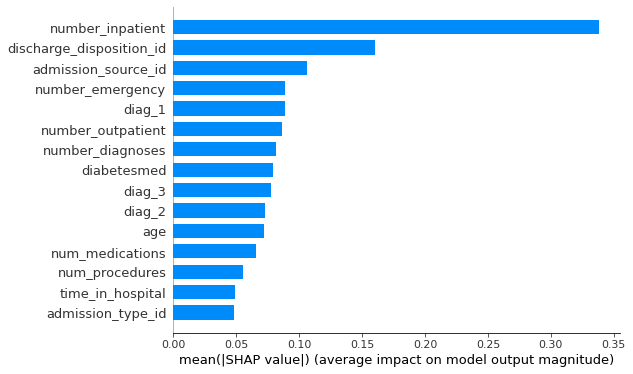

In [46]:
exp= shap.TreeExplainer(model)
vals= exp.shap_values(X_test[model.feature_names_])

shap.summary_plot(vals,
                  X_test[model.feature_names_],
                  max_display= 15,
                  plot_type='bar',
                  plot_size=.3)

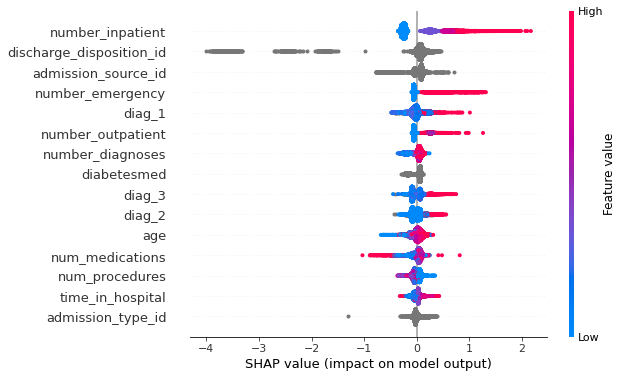

In [47]:
shap.summary_plot(vals,
                  X_test[model.feature_names_],
                  max_display= 15,
                  plot_type='dot',
                  plot_size=.3)

In [50]:
X_test.head(1)

,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,race
8163,Female,85,?,6,1,7,3,49,0,8,...,No,No,No,No,No,No,No,No,No,Caucasian


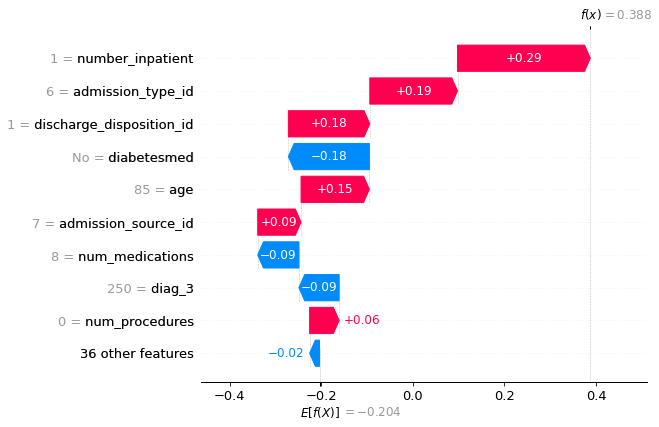

In [49]:
explainer   = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test.head(1))

plt.figure(figsize=(10,10))
fig= shap.plots.waterfall(shap_values[0], max_display=10)
plt.show()